In [1]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import shap

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)

cuda:0
1.8.0a0+52ea372


In [2]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [3]:
model = FashionCNN().to( device )
model.load_state_dict( torch.load("mnist_fashion_CNN.pt") )


<All keys matched successfully>

In [4]:
model.eval()

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [5]:
"""
    Data loading, train and test set via the PyTorch dataloader.
"""

train_transform=transforms.Compose([
#         transforms.RandomCrop(28, padding=4),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

test_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])

batch_size = 1000

trainset = datasets.FashionMNIST('./data', train=True, download=True,
                   transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = datasets.FashionMNIST('./data', train=False,
                   transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [6]:
len(trainset)

60000

In [7]:
batch = next(iter(test_loader))
images, labs = batch

In [8]:
images.shape

torch.Size([1000, 1, 28, 28])

In [9]:
background = images[:500]
background = background.to(device, dtype=torch.float)


In [10]:
test_images = images[500:]
test_images = test_images.cpu()
test_images = test_images.numpy()
pants = []
for i in range(len(test_images)):
    tru_lab = int(labs[500+i])
    if tru_lab ==1:
        pants.append(test_images[i])
pants_t = torch.FloatTensor(pants)

In [11]:
e = shap.DeepExplainer(model, background)

In [12]:
shap_values = e.shap_values(pants_t)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [13]:
shap_values = np.asarray(shap_values)
shap_values.shape

(10, 53, 1, 28, 28)

In [14]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]

shap_n = np.asarray(shap_numpy)
shap_n.shape

(10, 53, 28, 28, 1)

(53, 28, 28, 1)


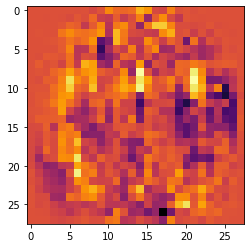

In [15]:
shap_heatmap = np.zeros((28,28))

snkr_shaps = shap_n[7]
print(snkr_shaps.shape)

for i in range(len(snkr_shaps)):
    shap_heatmap += snkr_shaps[i,:,:,0]
    

plt.imshow(shap_heatmap, cmap='inferno')
plt.show()

In [28]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [43]:
top5idxs = largest_indices(shap_heatmap, 5)

In [30]:
top10idxs = largest_indices(shap_heatmap, 10)
top10idxs

(array([ 9,  8, 10, 21,  8, 19, 10,  9, 25,  9]),
 array([21, 14, 14,  6, 21,  6, 21, 14, 20,  5]))

In [18]:
for i in range(10):
    print(shap_heatmap[top10idxs[0][i], top10idxs[1][i]])

5.62584228743799
5.585948307358194
5.203444090679113
5.16855482943356
4.914426076225936
4.789531297516078
4.728785552084446
4.672822481486946
4.629217755049467
4.476297967135906


In [31]:
import random

def perturb_indices(img, arr0, arr1, lo, hi):
    random.seed(123)
    assert(len(arr0) == len(arr1)) 
    img = img.numpy()
    new_img = np.copy(img)
    for i in range(len(arr0)):
        new_img[0,arr0[i], arr1[i]] += random.uniform(lo,hi)
    return new_img

In [34]:
new_i = perturb_indices(pants_t[0], top10idxs[0], top10idxs[1], 3,5)

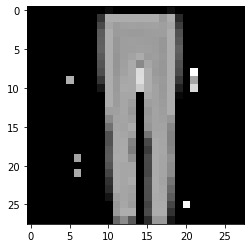

In [35]:
plt.imshow(new_i[0], cmap='gray')
plt.show()

In [36]:
new_i_t = torch.FloatTensor(new_i)
new_i_t = new_i_t.to(device, dtype=torch.float)
new_i_t = new_i_t.unsqueeze(0)
output = model(new_i_t)
outpt = F.softmax(output, dim=1)
print(outpt)
print(torch.argmax(outpt))

tensor([[1.5831e-02, 9.8417e-01, 7.8658e-09, 7.7415e-07, 8.9433e-07, 4.9796e-09,
         1.0224e-07, 2.6542e-11, 5.3553e-08, 6.6171e-12]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor(1, device='cuda:0')


In [39]:
def test_shap_pert(img, arr0, arr1, lo,hi):
    new_i = perturb_indices(img, arr0, arr1, lo,hi)
    new_i_t = torch.FloatTensor(new_i)
    new_i_t = new_i_t.to(device, dtype=torch.float)
    new_i_t = new_i_t.unsqueeze(0)
    
    output = model(new_i_t)
    outpt = F.softmax(output, dim=1)
    predicted_lab = torch.argmax(outpt)
    
    return new_i, outpt, predicted_lab
    

In [55]:
perted_imgs = []
perted_outs = []
pred_labs = []

for i in range(len(pants_t)):
    new_i, outpt, predicted_lab = test_shap_pert(pants_t[i], top5idxs[0], top5idxs[1], 3,5)
    perted_imgs.append(new_i)
    perted_outs.append(outpt)
    pred_labs.append(predicted_lab)

In [56]:
print(len(perted_outs))

c=0
for l in pred_labs:
    print(int(l), ',', end ="")
    if int(l) != 1:
        c+=1
print(c)

53
1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,4 ,3 ,1 ,1 ,1 ,1 ,1 ,4 ,1 ,1 ,1 ,3 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,4 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,5


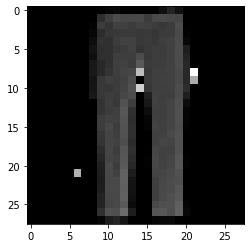

tensor(1, device='cuda:0')


In [49]:
plt.imshow(perted_imgs[3][0],cmap='gray')
plt.show()
print(pred_labs[23])


In [60]:
perted_imgs = []
perted_outs = []
pred_labs = []

for i in range(len(pants_t)):
    new_i, outpt, predicted_lab = test_shap_pert(pants_t[i], top10idxs[0], top10idxs[1], 5,8)
    perted_imgs.append(new_i)
    perted_outs.append(outpt)
    pred_labs.append(predicted_lab)

In [61]:
print(len(perted_outs))

c=0
for l in pred_labs:
    print(int(l), ',', end ="")
    if int(l) != 1:
        c+=1
print(c)

53
0 ,0 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,0 ,1 ,1 ,0 ,1 ,0 ,0 ,6 ,0 ,1 ,1 ,0 ,6 ,1 ,4 ,1 ,1 ,0 ,3 ,0 ,0 ,1 ,0 ,0 ,1 ,0 ,0 ,4 ,0 ,1 ,0 ,0 ,6 ,1 ,0 ,0 ,1 ,1 ,0 ,1 ,0 ,0 ,1 ,35


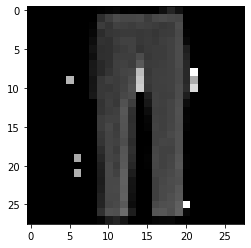

tensor(1, device='cuda:0')


In [62]:
plt.imshow(perted_imgs[3][0],cmap='gray')
plt.show()
print(pred_labs[23])


In [63]:
top20idxs = largest_indices(shap_heatmap, 20)

In [67]:
perted_imgs = []
perted_outs = []
pred_labs = []

for i in range(len(pants_t)):
    new_i, outpt, predicted_lab = test_shap_pert(pants_t[i], top20idxs[0], top20idxs[1], 5,8)
    perted_imgs.append(new_i)
    perted_outs.append(outpt)
    pred_labs.append(predicted_lab)

In [68]:
print(len(perted_outs))

c=0
for l in pred_labs:
    print(int(l), ',', end ="")
    if int(l) != 1:
        c+=1
print(c)

53
0 ,0 ,4 ,0 ,0 ,4 ,4 ,4 ,4 ,0 ,0 ,6 ,6 ,6 ,0 ,4 ,4 ,6 ,6 ,0 ,4 ,0 ,6 ,4 ,6 ,0 ,4 ,6 ,6 ,0 ,0 ,0 ,6 ,0 ,0 ,0 ,4 ,4 ,0 ,0 ,4 ,4 ,6 ,0 ,0 ,4 ,0 ,0 ,0 ,0 ,6 ,0 ,4 ,53


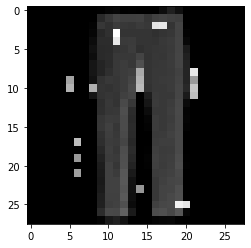

tensor(4, device='cuda:0')


In [69]:
plt.imshow(perted_imgs[3][0],cmap='gray')
plt.show()
print(pred_labs[23])
